In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, make_moons
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 2).astype(int).values    # virginica

<h2>Linear SVM Classfication</h2>

<h3>Linear kernel</h3>

Using linear kernel, perhaps not surprisingly, results in a linear decision boundary.

In [3]:
clf = make_pipeline(StandardScaler(),
                    SVC(kernel='linear', random_state=42))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', random_state=42))])

In [4]:
x0 = np.array([[5.5, 1.7], [5.0, 1.5]])
clf.predict(x0)

array([1, 0])

In [5]:
# Signed distance between each instance and the decision boundary
clf.decision_function(x0)

array([ 0.83293241, -0.40504826])

In [6]:
def plot_decision_boundary(X, y, clf, fs=(8,6)):
    # Create a meshgrid
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5    # X1 (feature 1)
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5    # X2 (feature 2)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    
    # Predict class label on each grid point
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot the decision boundary
    fig, ax = plt.subplots(figsize=fs)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Accent)
    
    # Define marker color and labels for each class
    markers = ['o', '^']
    colors = ['blue', 'green']
    class_labels = np.unique(y)
    class_names = ['non-virginica', 'virginica']
    
    # Plot the original data
    for i, label in enumerate(class_labels):
        X_sub = X[y == label]
        plt.scatter(X_sub[:,0], X_sub[:,1], marker=markers[i], color=colors[i], label=class_names[i])
    ax.set_xlabel('Petal length (cm)')
    ax.set_ylabel('Petal width (cm)')
    ax.legend();

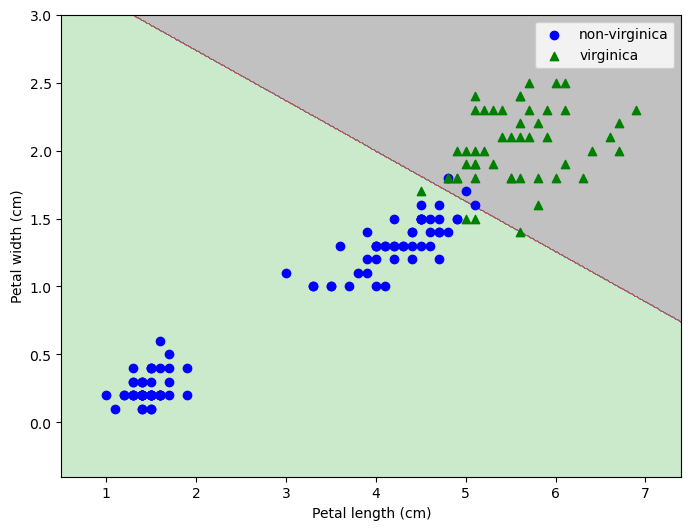

In [7]:
plot_decision_boundary(X, y, clf)

- As can be seen, the decision boundary is linear.
- Note that when using SVM with linear kernel, using `LinearSVC` is preferred over `SVC(kernel='linear')`, as it is much faster, especially if the training dataset is very large.

<h2>Non-linear SVM Classification</h2>

<h3>Polynomial kernel</h3>

In [4]:
X, y, = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
poly_kernel = make_pipeline(StandardScaler(),
                            SVC(kernel='poly', random_state=42))
poly_kernel.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly', random_state=42))])

In [8]:
def tune_svm(X, y):
    param_dist = {
        'C': np.linspace(1, 10, 100),
        'degree': np.arange(1,11),
        'coef0': np.arange(1,11)
    }
    random_search = RandomizedSearchCV(estimator=SVC(kernel='poly', random_state=42),
                                       param_distributions=param_dist,
                                       n_iter=20,
                                       cv=5,
                                       refit=True,
                                       scoring='accuracy',
                                       n_jobs=-1)
    random_search.fit(X, y)
    return random_search

`coef0`: 
- Controls how much the model is influenced by high-degree terms versus low degree terms.


`C`: 
- A regularization hyperparameter that controls the bias-variance trade-off.
- When C is small, the algorithm seek narrow margins that are rarely violated; this amounts to a classifier that is highly fit to the data, which may have low *bias* but high *variance*.
- When C is larger, the margin is wider and the algorithm allow more violations to it; this amounts to fitting the data less hard and obtaining a classifier that is potentially more biased but may have lower variance.

A few more notes on the `C` hyperparameter. It turns out that only observations that either lie *on* the margin or that *violate* the margin (i.e., are on side of the margin or even wrong side of the hyperplane) will affect the hyperplane that determines the obtained classifier. In other words, an observation that lies strictly on the correct side of the margin does not affect the support vector classifier (changing the position of that observation would not change the classifier at all, provided that its position remains on the correct side of the margin). Observations that lie directly on the margin or on the wrong side of the margin w.r.t. their class, are known as *support vectors* (these support vectors define the classifier). When the hyperparameter `C` is large, then the margin is wide, many observations violate the margin, and so there are many support vectors. In this case, many observations are involved in determining the hyperplane (that defines the classifier), which leads to higher bias but lower variance. In contrast, if `C` is small, then there will be fewer support vectors, and hence the resulting classifier will have lower bias, but higher variance. It is not hard to see that this is the reason that `C` plays a vital role in the *bias-variance* *trade-off*.

In [9]:
poly_kernel_tuned = tune_svm(X_train, y_train)

In [11]:
best_params = poly_kernel_tuned.best_params_

In [39]:
def plot_db(X, y, clf, ax, title):
    # Create a meshgrid
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5    # X1 (feature 1)
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5    # X2 (feature 2)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    
    # Predict class label on each grid point
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Accent)
    
    # Define markers and colors for each class
    markers = ['o', '^']
    colors = ['black', 'orange']
    
    # Plot the original data
    for i, label in enumerate(np.unique(y)):
        X_sub = X[y == label]
        ax.scatter(X_sub[:,0], X_sub[:,1], marker=markers[i], color=colors[i])
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(title)
    plt.tight_layout();

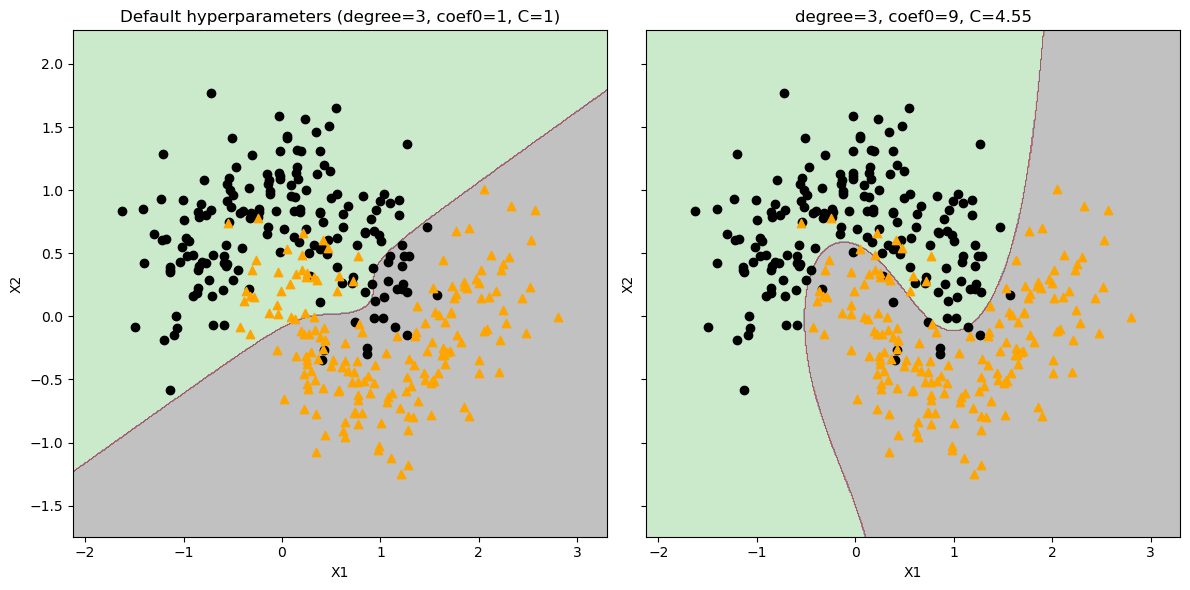

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
plot_db(X=X_train, 
        y=y_train, 
        clf=poly_kernel, 
        ax=ax[0], 
        title='Default hyperparameters (degree=3, coef0=1, C=1)')
plot_db(X=X_train, 
        y=y_train, 
        clf=poly_kernel_tuned, 
        ax=ax[1], 
        title=f'degree={best_params['degree']}, coef0={best_params['coef0']}, C={best_params['C']:.2f}')

In [41]:
# Test accuracy on default settings
accuracy_score(y_true=y_test, y_pred=poly_kernel.predict(X_test))

0.8466666666666667

In [42]:
# Test accuracy on a slightly tuned SVM
accuracy_score(y_true=y_test, y_pred=poly_kernel_tuned.predict(X_test))

0.9

<h3>Gaussian RBF kernel</h3>

In [36]:
def tune_rbf_kernel(X, y):
    param_dist = {
        'C': np.linspace(1, 11, 100),
        'gamma': list(np.linspace(0.0, 5.0, 100))
    }
    random_search = RandomizedSearchCV(estimator=SVC(kernel='rbf', random_state=42),
                                       param_distributions=param_dist,
                                       n_iter=10000,
                                       cv=10,
                                       refit=True,
                                       scoring='accuracy',
                                       n_jobs=-1)
    random_search.fit(X, y)
    return random_search

`gamma`:
- Like the `C` hyperparameter, `gamma` also acts as a regularization hyperparameter.
- To reduce variance (i.e., if your model is overfitting), one should reduce the value of `gamma`. 
- To reduce bias (i.e., if your model is underfitting), one should increase the value of `gamma`.

In [37]:
rbf_kernel_tuned = tune_rbf_kernel(X_train, y_train)

In [38]:
rbf_kernel_tuned.best_params_

{'gamma': np.float64(1.3636363636363635), 'C': np.float64(2.4141414141414144)}

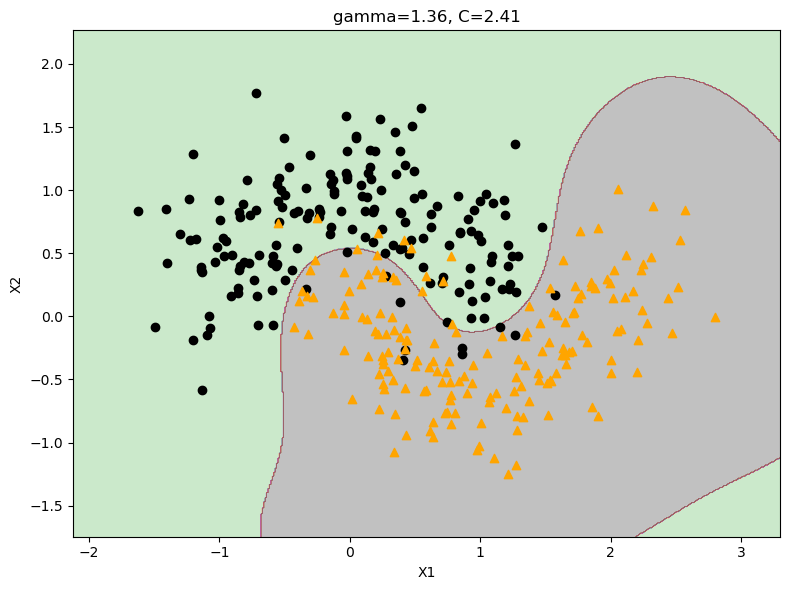

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
plot_db(X=X_train, 
        y=y_train,
        clf=rbf_kernel_tuned,
        ax=ax,
        title=f'gamma={rbf_kernel_tuned.best_params_['gamma']:.2f}, C={rbf_kernel_tuned.best_params_['C']:.2f}')

In [46]:
# Accuracy on RBF kernel
accuracy_score(y_true=y_test, y_pred=rbf_kernel_tuned.predict(X_test))

0.9066666666666666